# Import libraries

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import random

# Define `read_coordinates` Function
This function reads the coordinates from a CSV file and returns a list of tuples containing the coordinates.
- `file_path`: The path to the CSV file.
- `coordinates`: List of tuples containing the (x, y) coordinates.

In [ ]:
def read_coordinates(file_path):
    coordinates = []
    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            x = float(row['x'])
            y = float(row['y'])
            coordinates.append((x, y))
    return coordinates

# Define `TSPSolver` Class and `__init__` Method
The `TSPSolver` class encapsulates the Ant Colony Optimization algorithm for solving the TSP problem.
- `__init__`: Initializes the class with the given parameters.
- `coordinates`: List of city coordinates.
- `num_ants`: Number of ants to use in the algorithm.
- `num_iterations`: Number of iterations to run the algorithm.
- `alpha`: Importance of pheromone.
- `beta`: Importance of heuristic.
- `evaporation_rate`: Rate at which pheromone evaporates.
- `Q`: Constant used in pheromone update.
- `initial_pheromone`: Initial pheromone level.
- `random_seed`: Seed for random number generator to ensure reproducibility.




1. **Initialization**: The class is initialized with parameters such as coordinates of cities, number of ants, number of iterations, alpha, beta, evaporation rate, Q (pheromone constant), initial pheromone level, and random seed.

2. **Distance Matrix Calculation**: It calculates the distance matrix based on the coordinates of the cities.

3. **Probability Calculation**: It calculates the probabilities for each city to be chosen as the next city for an ant to visit, based on pheromone levels and distances.

4. **Solution Construction**: It constructs a solution by iteratively selecting the next city for each ant based on probabilities until all cities are visited.

5. **Total Distance Calculation**: It calculates the total distance of a solution by summing the distances between consecutive cities and adding the distance back to the starting city.

6. **Pheromone Update**: It updates the pheromone levels on the edges based on the quality of solutions found by the ants.

7. **Solution Search**: It iterates through a fixed number of iterations, constructing solutions, updating pheromones, and keeping track of the best solution found so far.

8. **Solution Plotting**: It plots the best solution found at regular intervals during the iterations.

9. **Print Best Solution**: It prints the best path found along with the total distance.

In [14]:
class TSPSolver:
    def __init__(self, coordinates, num_ants=15, num_iterations=100, alpha=1.0, beta=5.0, evaporation_rate=0.5, Q=100, initial_pheromone=None, random_seed=None):
        self.coordinates = coordinates
        self.num_cities = len(coordinates)
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        self.distance_matrix = self.calculate_distance_matrix()
        self.pheromones = np.ones((self.num_cities, self.num_cities)) / self.num_cities if initial_pheromone is None else np.full((self.num_cities, self.num_cities), initial_pheromone)
        self.best_solution = None
        self.best_distance = float('inf')
        if random_seed is not None:
            random.seed(random_seed)
            np.random.seed(random_seed)

    def calculate_distance_matrix(self):
        distance_matrix = np.zeros((self.num_cities, self.num_cities))
        for i in range(self.num_cities):
            for j in range(self.num_cities):
                if i != j:
                    distance_matrix[i][j] = np.sqrt((self.coordinates[i][0] - self.coordinates[j][0]) ** 2 +
                                                    (self.coordinates[i][1] - self.coordinates[j][1]) ** 2)
        return distance_matrix

    def calculate_probabilities(self, pheromones, distances, alpha, beta, current_city, visited):
        probabilities = np.zeros(self.num_cities)
        pheromones_alpha = pheromones[current_city] ** alpha
        distances_beta = (1.0 / distances[current_city]) ** beta
        for j in range(self.num_cities):
            if j not in visited:
                probabilities[j] = pheromones_alpha[j] * distances_beta[j]
        probabilities_sum = np.sum(probabilities)
        return probabilities / probabilities_sum if probabilities_sum > 0 else probabilities

    def construct_solution(self):
        solution = [random.randint(0, self.num_cities - 1)]
        visited = set(solution)
        while len(solution) < self.num_cities:
            current_city = solution[-1]
            probabilities = self.calculate_probabilities(self.pheromones, self.distance_matrix, self.alpha, self.beta, current_city, visited)
            next_city = np.random.choice(range(self.num_cities), p=probabilities)
            solution.append(next_city)
            visited.add(next_city)
        return solution

    def calculate_total_distance(self, solution):
        total_distance = 0.0
        for i in range(len(solution) - 1):
            total_distance += self.distance_matrix[solution[i]][solution[i + 1]]
        total_distance += self.distance_matrix[solution[-1]][solution[0]]  # Return to the start city
        return total_distance

    def update_pheromones(self, solutions):
        self.pheromones *= (1 - self.evaporation_rate)
        for solution in solutions:
            total_distance = self.calculate_total_distance(solution)
            for i in range(len(solution) - 1):
                self.pheromones[solution[i]][solution[i + 1]] += self.Q / total_distance
            self.pheromones[solution[-1]][solution[0]] += self.Q / total_distance  # Return to the start city

    def solve(self):
        for iteration in range(self.num_iterations):
            solutions = [self.construct_solution() for _ in range(self.num_ants)]
            for solution in solutions:
                total_distance = self.calculate_total_distance(solution)
                if total_distance < self.best_distance:
                    self.best_distance = total_distance
                    self.best_solution = solution
            self.update_pheromones(solutions)
            if (iteration + 1) % 20 == 0:
                self.plot_solution(iteration + 1)

        return self.best_solution, self.best_distance

    def plot_solution(self, iteration):
        plt.figure(figsize=(10, 6))
        for i in range(len(self.best_solution) - 1):
            city1 = self.coordinates[self.best_solution[i]]
            city2 = self.coordinates[self.best_solution[i + 1]]
            plt.plot([city1[0], city2[0]], [city1[1], city2[1]], 'bo-')
        city1 = self.coordinates[self.best_solution[-1]]
        city2 = self.coordinates[self.best_solution[0]]
        plt.plot([city1[0], city2[0]], [city1[1], city2[1]], 'bo-')
        plt.title(f'Iteration {iteration}: Best Distance = {self.best_distance:.2f}')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.show()

    def print_best_solution(self):
        print("Best path found:")
        print(" -> ".join(str(city + 1) for city in self.best_solution))
        print(f"Total distance: {self.best_distance:.2f}")

# Load Data and Run Solver

In [ ]:
file_path = '/content/Data set CSV.csv'
coordinates = read_coordinates(file_path)

<ipython-input-14-2256659732f8>:31: RuntimeWarning: divide by zero encountered in divide
  distances_beta = (1.0 / distances[current_city]) ** beta


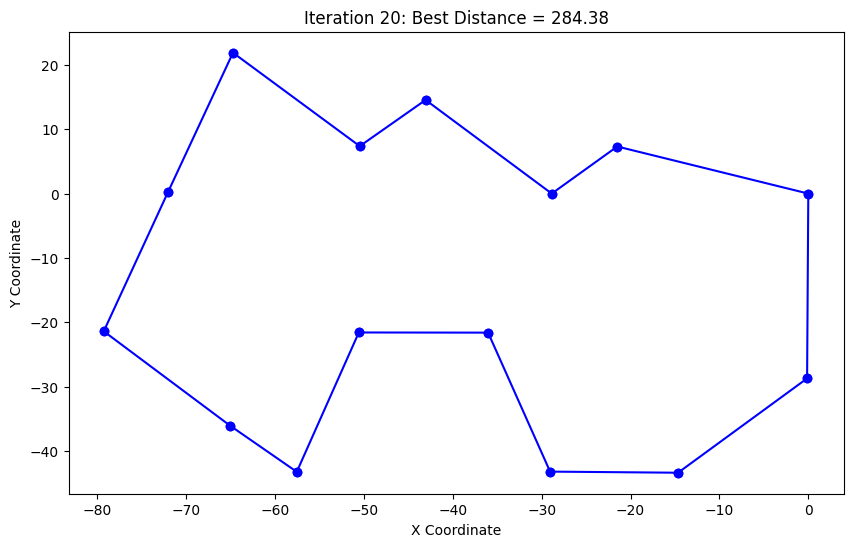

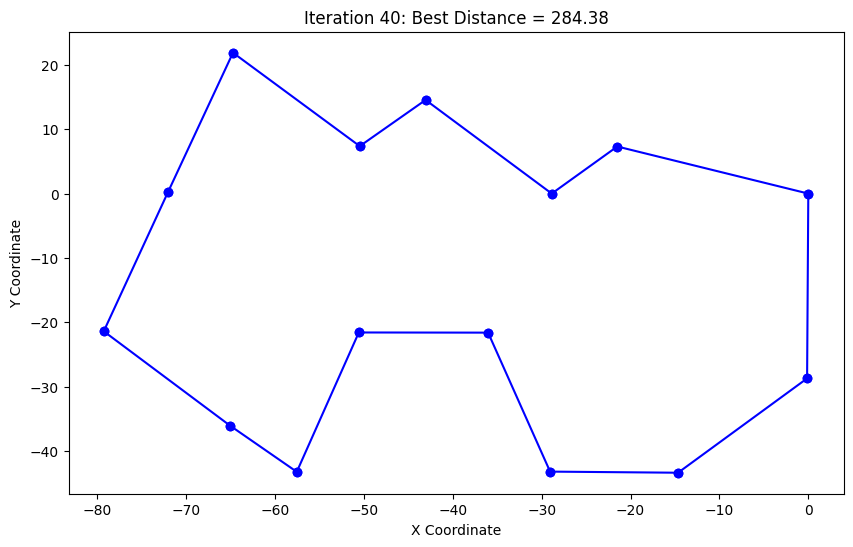

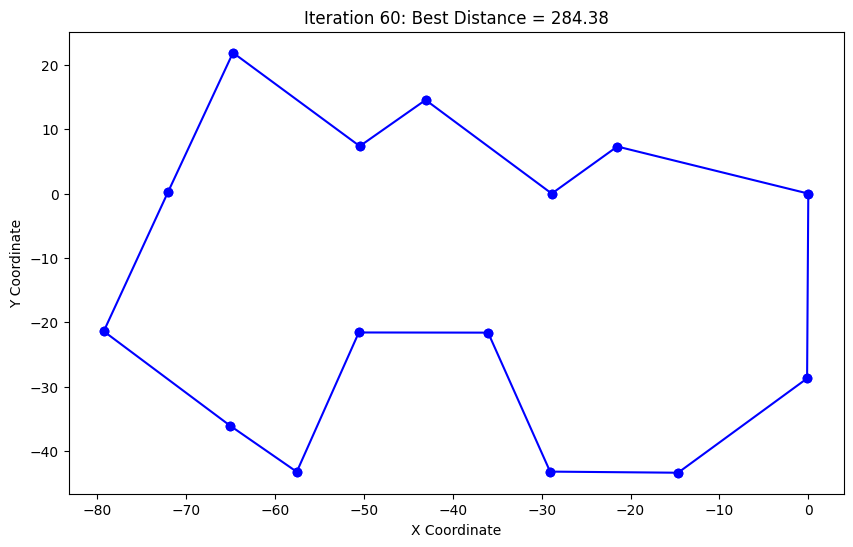

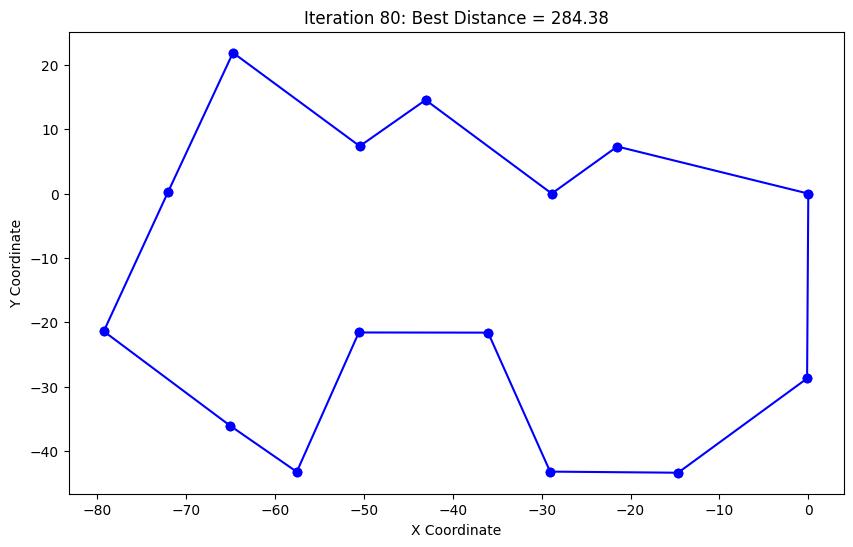

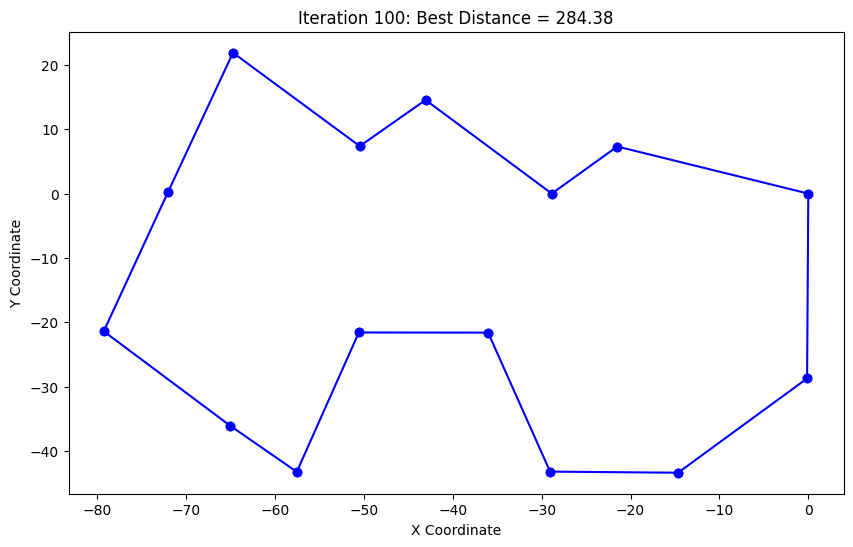

In [19]:
solver = TSPSolver(coordinates, num_ants=20, num_iterations=100, alpha=.90, beta=5.0, evaporation_rate=0.3, Q=100, initial_pheromone=.50, random_seed=42)
best_solution, best_distance = solver.solve()

In [16]:
solver.print_best_solution()

Best path found:
5 -> 9 -> 15 -> 2 -> 13 -> 1 -> 11 -> 4 -> 6 -> 8 -> 10 -> 14 -> 12 -> 3 -> 7
Total distance: 284.38


#  Try Different Initialization

<ipython-input-14-2256659732f8>:31: RuntimeWarning: divide by zero encountered in divide
  distances_beta = (1.0 / distances[current_city]) ** beta


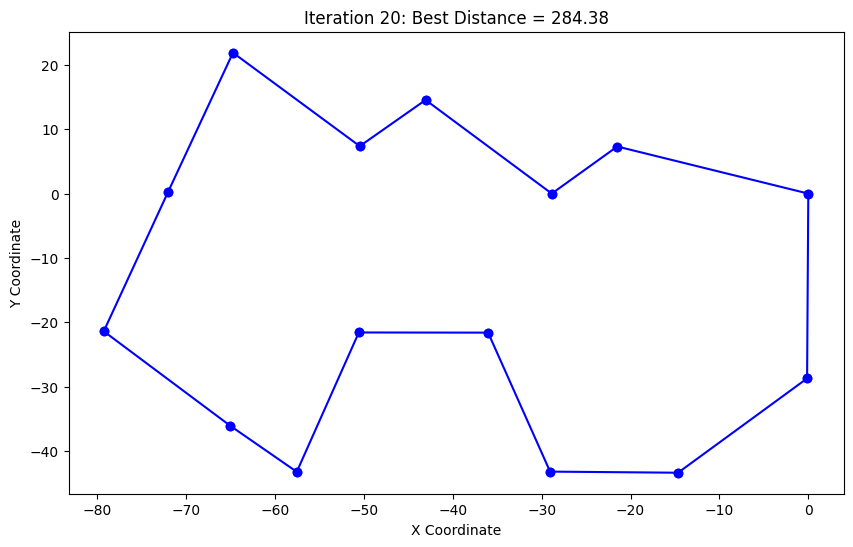

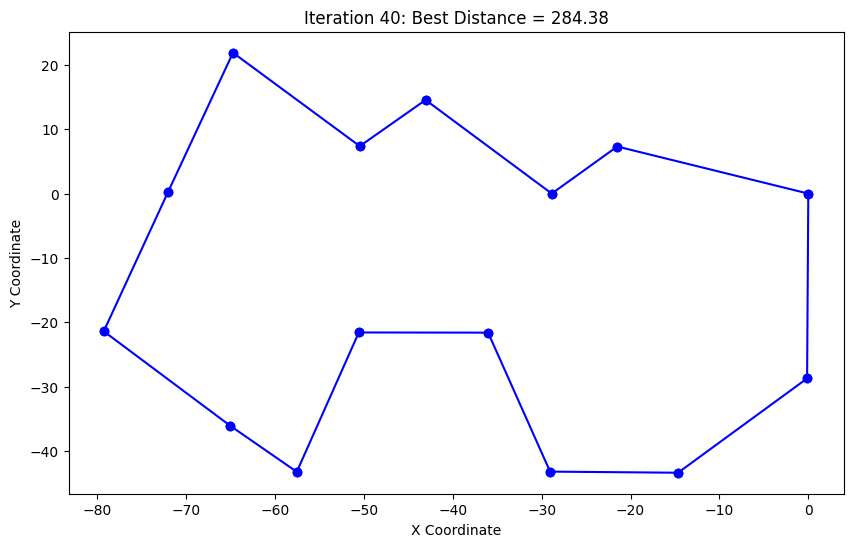

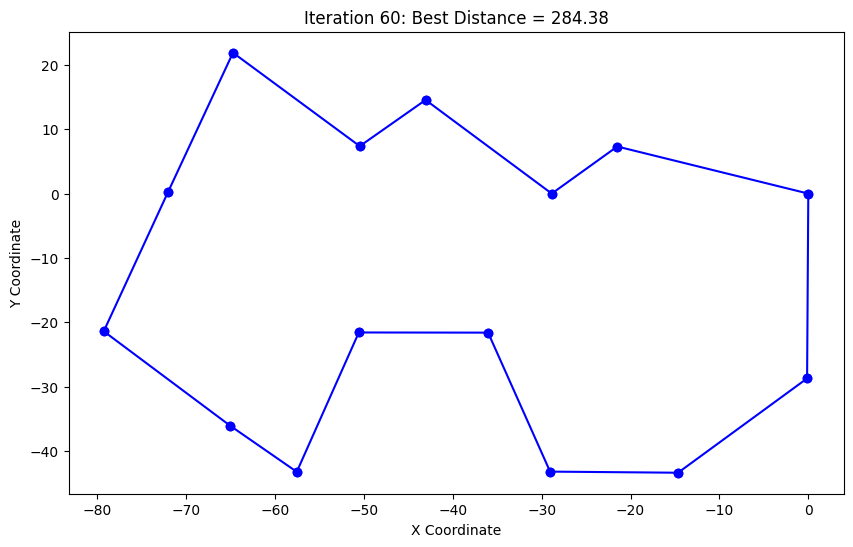

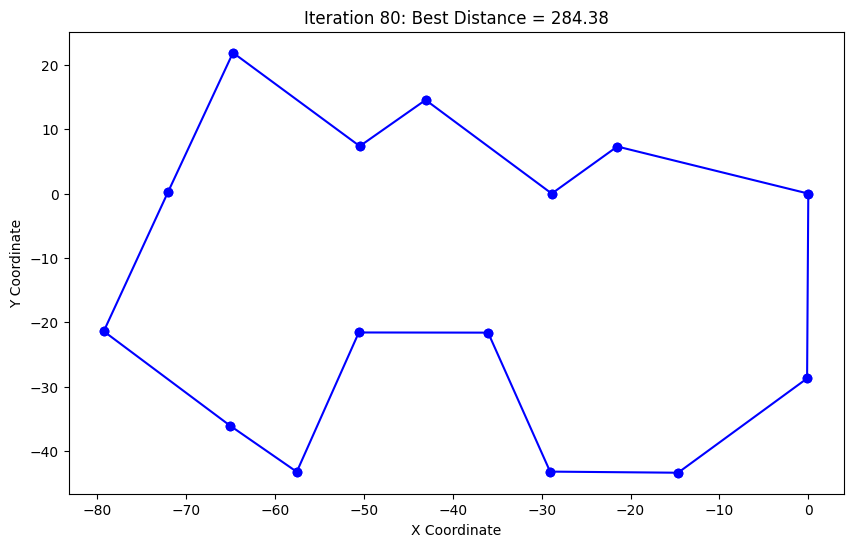

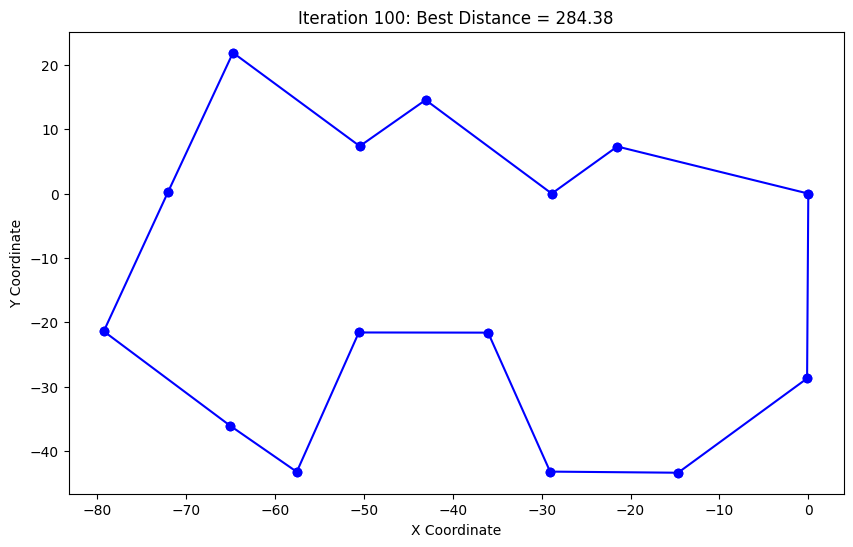

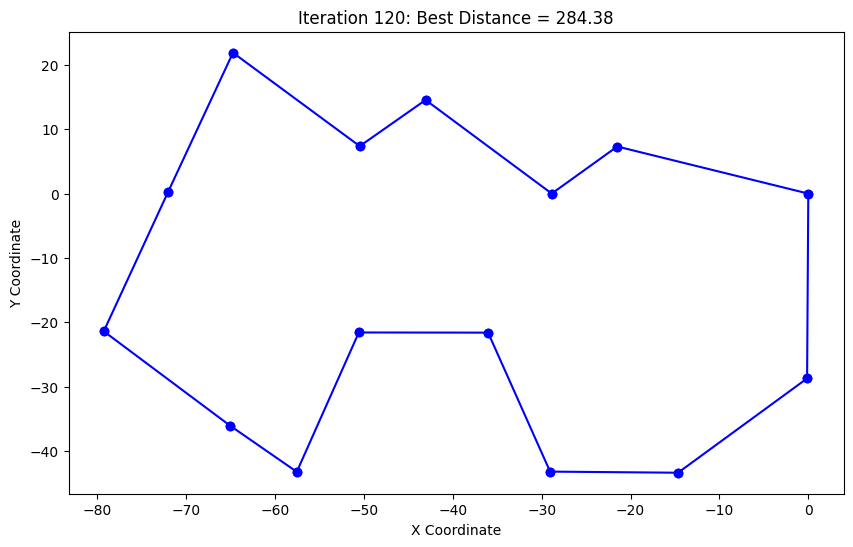

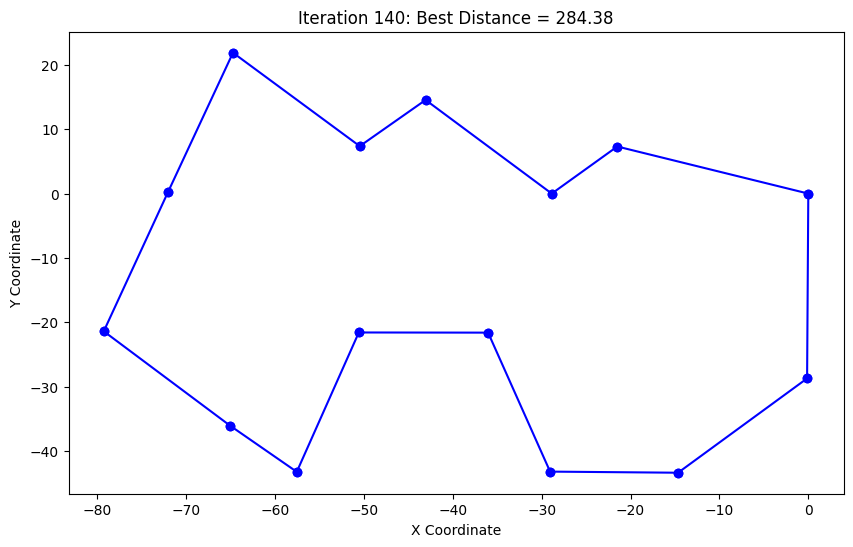

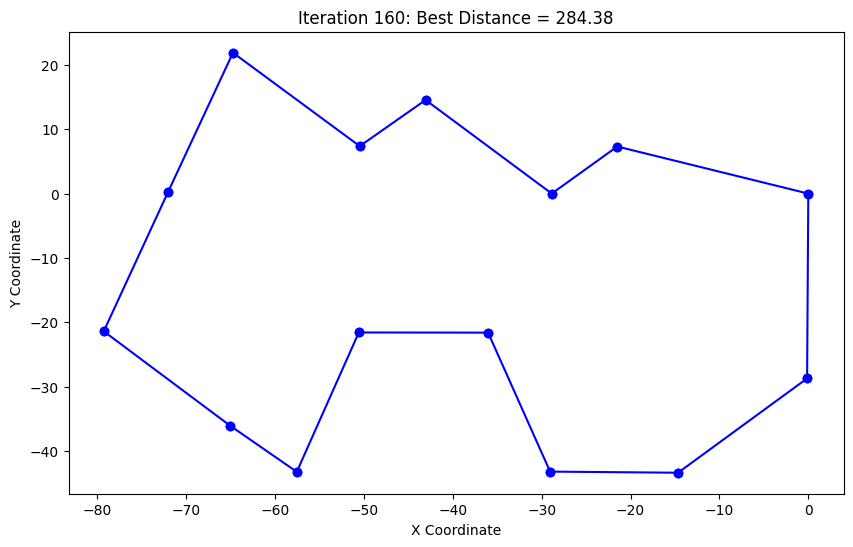

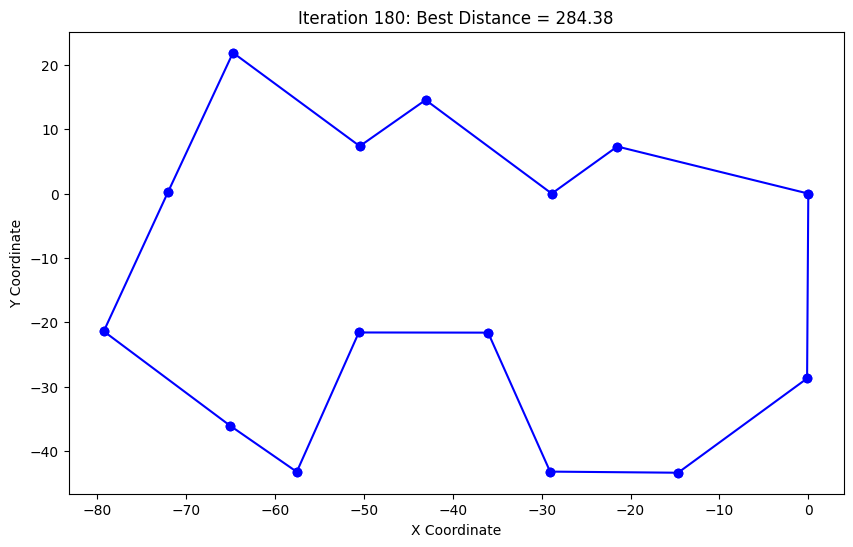

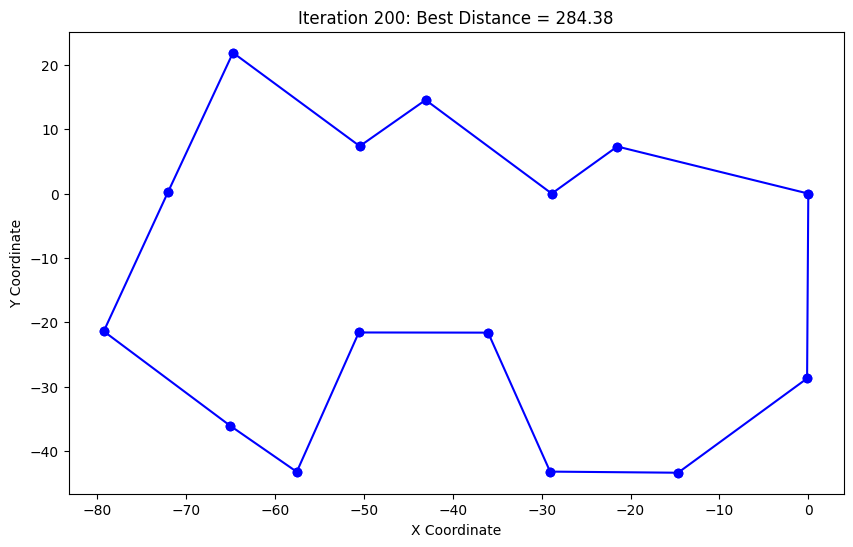

In [18]:
solver = TSPSolver(coordinates, num_ants=20, num_iterations=200, alpha=2.0, beta=5.0, evaporation_rate=0.3, Q=100, initial_pheromone=1.0, random_seed=100)
best_solution, best_distance = solver.solve()

In [20]:
solver.print_best_solution()

Best path found:
12 -> 14 -> 10 -> 8 -> 6 -> 4 -> 11 -> 1 -> 13 -> 2 -> 15 -> 9 -> 5 -> 7 -> 3
Total distance: 284.38
